In [7]:
from astroquery.sdss import SDSS
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from specutils import Spectrum1D
from labellines import labelLines
import matplotlib.axes as axes
import pandas as pd
import seaborn as sns
from scipy.optimize import curve_fit

plt.rcParams['agg.path.chunksize'] = 120

In [8]:
pd.set_option('display.max_colwidth', None)
import warnings
warnings.filterwarnings('ignore') #ignore warnings

In [9]:
eboss_fits = fits.open('eboss_dr17_summary_edapv10_cigale.fit', memmap=True)

eboss_data = eboss_fits[1].data #eboss_data = data for the fit file
eboss_fits.info() #shows information on the data
print(eboss_fits[1].columns) #prints values on column for future use

Filename: eboss_dr17_summary_edapv10_cigale.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU    235   1898753R x 109C   ['J', 'J', 'J', '16A', 'D', 'E', 'D', 'D', 'E', '118A', '4A', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', '9A', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', '8E', '8E', '8E', '8E', '5E', '5E', '5E', '5E', 'E', 'E', 'A', 'A', 'A', 'I', 'I', 'I']   
ColDefs(
    name = 'PLATE'; format = 'J'
    name = 'MJD'; format = 'J'
    name = 'FIBER'; format = 'J'
    name = 'PMF_STRING'; format = '16A'
    name = 'Z'; format = 'D'
    name = 'Z_ERR'; format = 'E'
    nam

In [13]:
# Remove possible +/- inf values
gals_flux = eboss_data[(eboss_data['H_BETA_FLUX']>0) & (eboss_data['OIII_5007_FLUX_ERR']>0) 
             & (eboss_data['H_ALPHA_FLUX']>0) & (eboss_data['NII_6584_FLUX']>0)]
err_range = 3

# Make sure relavent emission lines have well measured fluxes
quality_gals = gals_flux[((gals_flux['OIII_5007_FLUX']/gals_flux['OIII_5007_FLUX_ERR'])>err_range) &
                ((gals_flux['H_BETA_FLUX']/gals_flux['H_BETA_FLUX_ERR'])>err_range) &
                ((gals_flux['H_ALPHA_FLUX']/gals_flux['H_ALPHA_FLUX_ERR'])>err_range) &
                ((gals_flux['NII_6584_FLUX']/gals_flux['NII_6584_FLUX_ERR'])>err_range) & (gals_flux['Z']<0.15)] #signal to noise ratio filter

gals_sf = quality_gals[quality_gals['SFG']==1]
gals_agn = quality_gals[quality_gals['AGN']==1]

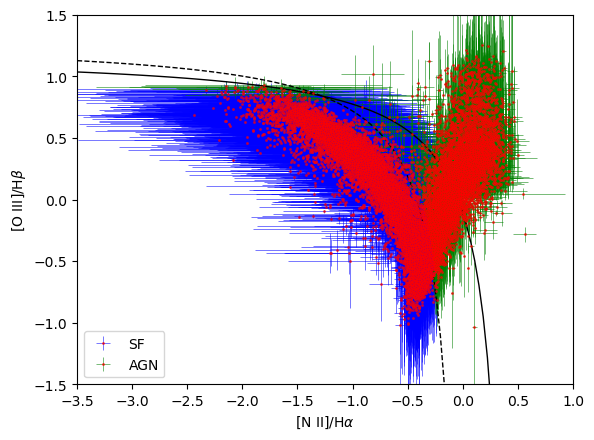

In [197]:
def make_bpt_plot():

    ln10 = 0.4342944819

    oiii_Hb_sf = np.log10(gals_sf['OIII_5007_FLUX']/gals_sf['H_BETA_FLUX'])
    oiii_Hb_agn = np.log10(gals_agn['OIII_5007_FLUX']/gals_agn['H_BETA_FLUX'])

    oiii_Hb_sf_err = np.abs(np.sqrt((gals_sf['OIII_5007_FLUX_ERR']/(gals_sf['OIII_5007_FLUX']*ln10))**2+(gals_sf['H_BETA_FLUX_ERR']/(gals_sf['H_BETA_FLUX']*ln10))**2)*oiii_Hb_sf)
    oiii_Hb_agn_err = np.abs(np.sqrt((gals_agn['OIII_5007_FLUX_ERR']/(gals_agn['OIII_5007_FLUX']*ln10))**2+(gals_agn['H_BETA_FLUX_ERR']/(gals_agn['H_BETA_FLUX']*ln10))**2)*oiii_Hb_agn)
    
    nii_Ha_sf = np.log10(gals_sf['NII_6584_FLUX']/gals_sf['H_ALPHA_FLUX'])
    nii_Ha_agn = np.log10(gals_agn['NII_6584_FLUX']/gals_agn['H_ALPHA_FLUX'])
    
    nii_Ha_sf_err = np.abs(np.sqrt((gals_sf['NII_6584_FLUX_ERR']/(gals_sf['NII_6584_FLUX']*ln10))**2+(gals_sf['H_ALPHA_FLUX_ERR']/(gals_sf['H_ALPHA_FLUX']*ln10))**2)*nii_Ha_sf)
    nii_Ha_agn_err = np.abs(np.sqrt((gals_agn['NII_6584_FLUX_ERR']/(gals_agn['NII_6584_FLUX']*ln10))**2+(gals_agn['H_ALPHA_FLUX_ERR']/(gals_agn['H_ALPHA_FLUX']*ln10))**2)*nii_Ha_agn)

    plt.errorbar(nii_Ha_sf,oiii_Hb_sf, yerr=oiii_Hb_sf_err, xerr=nii_Ha_sf_err, fmt='o', color='blue',label='SF',markersize=1, markeredgecolor="red", alpha=0.75, elinewidth=0.5)
    plt.errorbar(nii_Ha_agn,oiii_Hb_agn, yerr=oiii_Hb_agn_err, xerr=nii_Ha_agn_err, fmt='o', color='green',label='AGN',markersize=1, markeredgecolor="red", alpha=0.75, elinewidth=0.5)

    comp_n2ha = np.linspace(-3.5,-0.1,100)
    comp_o3hb = 0.61/(comp_n2ha-0.05)+1.3
    plt.plot(comp_n2ha,comp_o3hb,color='k',linestyle='--',linewidth=1.0)

    agn_n2ha = np.linspace(-3.5,0.3,100)
    agn_o2hb = 0.61/(agn_n2ha-0.47)+1.19
    plt.plot(agn_n2ha,agn_o2hb,color='k',linewidth=1.0)

    plt.xlabel(r'[N II]/H$\alpha$')
    plt.ylabel(r'[O III]/H$\beta$')

    plt.xlim(-3.5,1)
    plt.ylim(-1.5,1.5)

    plt.legend()

######
    
make_bpt_plot()
plt.savefig("BPT_Diagram_err.jpeg")
plt.show()

[0.8571881] [0.18561922]
[0.9567359] [1.6248753] [9.649732] [389.15616]
[-2.379304] [0.6316895]


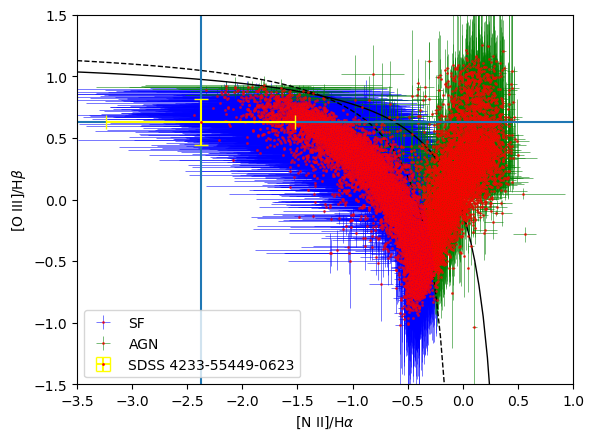

In [199]:
make_bpt_plot()

plate = 4233
mjd = 55449
fiber = 623

ln10 = 0.4342944819

galaxy = eboss_data[(eboss_data['PLATE'] == plate) & (eboss_data['MJD'] == mjd) &(eboss_data['FIBER'] == fiber)]

h_alpha = galaxy['H_ALPHA_FLUX']
h_beta = galaxy['H_BETA_FLUX']
nII = galaxy['NII_6584_FLUX']
oIII = galaxy['OIII_5007_FLUX']
yline=np.log10(nII/h_alpha)
xline=np.log10(oIII/h_beta)

y_err = np.abs(np.sqrt((galaxy['OIII_5007_FLUX_ERR']/(galaxy['OIII_5007_FLUX']*ln10))**2+(galaxy['H_BETA_FLUX_ERR']/(galaxy['H_BETA_FLUX']*ln10))**2)*yline)
x_err = np.abs(np.sqrt((galaxy['NII_6584_FLUX_ERR']/(galaxy['NII_6584_FLUX']*ln10))**2+(galaxy['H_ALPHA_FLUX_ERR']/(galaxy['H_ALPHA_FLUX']*ln10))**2)*xline)
print(x_err, y_err)
print(galaxy['NII_6584_FLUX_ERR'],galaxy['NII_6584_FLUX'],galaxy['H_ALPHA_FLUX_ERR'],galaxy['H_ALPHA_FLUX'])
print(yline, xline)

plt.axvline(yline, zorder=2.5)
plt.axhline(xline, zorder=2.5)
plt.errorbar(yline, xline, yerr=y_err, xerr=x_err, fmt='o', color='yellow',markersize=1, zorder=2.5, capsize=5, markeredgecolor="red", label='SDSS 4233-55449-0623')
plt.savefig("BPT_Diagram_w_SDSS.jpeg")
plt.legend()
plt.show()


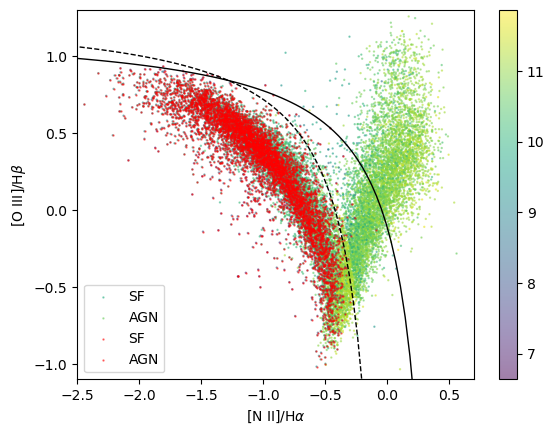

In [222]:
def make_bpt_plot_mass_grad():

    ln10 = 0.4342944819

    oiii_Hb_sf = np.log10(gals_sf['OIII_5007_FLUX']/gals_sf['H_BETA_FLUX'])
    oiii_Hb_agn = np.log10(gals_agn['OIII_5007_FLUX']/gals_agn['H_BETA_FLUX'])

    oiii_Hb_sf_err = np.abs(np.sqrt((gals_sf['OIII_5007_FLUX_ERR']/(gals_sf['OIII_5007_FLUX']*ln10))**2+(gals_sf['H_BETA_FLUX_ERR']/(gals_sf['H_BETA_FLUX']*ln10))**2)*oiii_Hb_sf)
    oiii_Hb_agn_err = np.abs(np.sqrt((gals_agn['OIII_5007_FLUX_ERR']/(gals_agn['OIII_5007_FLUX']*ln10))**2+(gals_agn['H_BETA_FLUX_ERR']/(gals_agn['H_BETA_FLUX']*ln10))**2)*oiii_Hb_agn)
    
    nii_Ha_sf = np.log10(gals_sf['NII_6584_FLUX']/gals_sf['H_ALPHA_FLUX'])
    nii_Ha_agn = np.log10(gals_agn['NII_6584_FLUX']/gals_agn['H_ALPHA_FLUX'])
    
    plt.scatter(nii_Ha_sf,oiii_Hb_sf, c=gals_sf["LOGMSTAR"], cmap='viridis',label='SF',alpha=0.5, s=0.5)
    plt.scatter(nii_Ha_agn,oiii_Hb_agn, c=gals_agn["LOGMSTAR"], cmap='viridis',label='AGN',alpha=0.5,s=0.5)
    plt.colorbar() 

    #mass < 8.5

    gals_sf_mass = gals_sf[gals_sf["LOGMSTAR"]<8.5]
    gals_agn_mass = gals_agn[gals_agn["LOGMSTAR"]<8.5]
    
    oiii_Hb_sf_mass = np.log10(gals_sf_mass['OIII_5007_FLUX']/gals_sf_mass['H_BETA_FLUX'])
    oiii_Hb_agn_mass = np.log10(gals_agn_mass['OIII_5007_FLUX']/gals_agn_mass['H_BETA_FLUX'])

    nii_Ha_sf_mass = np.log10(gals_sf_mass['NII_6584_FLUX']/gals_sf_mass['H_ALPHA_FLUX'])
    nii_Ha_agn_mass = np.log10(gals_agn_mass['NII_6584_FLUX']/gals_agn_mass['H_ALPHA_FLUX'])

    plt.scatter(nii_Ha_sf_mass,oiii_Hb_sf_mass, color="red",label='SF',alpha=0.5, s=0.5)
    plt.scatter(nii_Ha_agn_mass,oiii_Hb_agn_mass, color="red",label='AGN',alpha=0.5,s=0.5)
    
    comp_n2ha = np.linspace(-3.5,-0.1,100)
    comp_o3hb = 0.61/(comp_n2ha-0.05)+1.3
    plt.plot(comp_n2ha,comp_o3hb,color='k',linestyle='--',linewidth=1.0)

    agn_n2ha = np.linspace(-3.5,0.3,100)
    agn_o2hb = 0.61/(agn_n2ha-0.47)+1.19

    plt.plot(agn_n2ha,agn_o2hb,color='k',linewidth=1.0)

    plt.xlabel(r'[N II]/H$\alpha$')
    plt.ylabel(r'[O III]/H$\beta$')

    plt.xlim(-2.5,0.7)
    plt.ylim(-1.1,1.3)

    plt.legend()

######
    
make_bpt_plot_mass_grad()
plt.savefig("BPT_Diagram_mass_8oh5.jpeg")
plt.show()

[7.0432763]
[28.29982891] [1.07781419]
(28.29985917, 1.07783053)


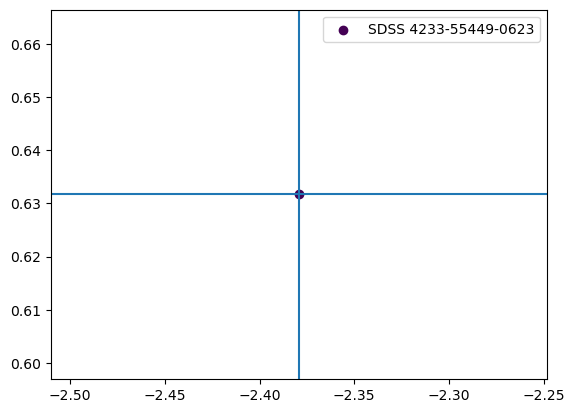

In [17]:
#make_bpt_plot_mass_grad()

plate = 4233
mjd = 55449
fiber = 623

ln10 = 0.4342944819

galaxy = eboss_data[(eboss_data['PLATE'] == plate) & (eboss_data['MJD'] == mjd) &(eboss_data['FIBER'] == fiber)]

h_alpha = galaxy['H_ALPHA_FLUX']
h_beta = galaxy['H_BETA_FLUX']
nII = galaxy['NII_6584_FLUX']
oIII = galaxy['OIII_5007_FLUX']
yline=np.log10(nII/h_alpha)
xline=np.log10(oIII/h_beta)
print(galaxy["LOGMSTAR"])
print(galaxy["RA"], galaxy["DEC"])
print(( 28.29985917,  1.07783053))

plt.axvline(yline, zorder=2.5)
plt.axhline(xline, zorder=2.5)
plt.scatter(yline, xline, c=galaxy["LOGMSTAR"], cmap='viridis', label='SDSS 4233-55449-0623')
plt.savefig("BPT_Diagram_mass_w_SDSS.jpeg")
plt.legend()
plt.show()


In [ ]:
def make_bpt_plot_mass_grad():

    ln10 = 0.4342944819

    oiii_Hb_sf = np.log10(gals_sf['OIII_5007_FLUX']/gals_sf['H_BETA_FLUX'])
    oiii_Hb_agn = np.log10(gals_agn['OIII_5007_FLUX']/gals_agn['H_BETA_FLUX'])

    oiii_Hb_sf_err = np.abs(np.sqrt((gals_sf['OIII_5007_FLUX_ERR']/(gals_sf['OIII_5007_FLUX']*ln10))**2+(gals_sf['H_BETA_FLUX_ERR']/(gals_sf['H_BETA_FLUX']*ln10))**2)*oiii_Hb_sf)
    oiii_Hb_agn_err = np.abs(np.sqrt((gals_agn['OIII_5007_FLUX_ERR']/(gals_agn['OIII_5007_FLUX']*ln10))**2+(gals_agn['H_BETA_FLUX_ERR']/(gals_agn['H_BETA_FLUX']*ln10))**2)*oiii_Hb_agn)
    
    nii_Ha_sf = np.log10(gals_sf['NII_6584_FLUX']/gals_sf['H_ALPHA_FLUX'])
    nii_Ha_agn = np.log10(gals_agn['NII_6584_FLUX']/gals_agn['H_ALPHA_FLUX'])
    
    nii_Ha_sf_err = np.abs(np.sqrt((gals_sf['NII_6584_FLUX_ERR']/(gals_sf['NII_6584_FLUX']*ln10))**2+(gals_sf['H_ALPHA_FLUX_ERR']/(gals_sf['H_ALPHA_FLUX']*ln10))**2)*nii_Ha_sf)
    nii_Ha_agn_err = np.abs(np.sqrt((gals_agn['NII_6584_FLUX_ERR']/(gals_agn['NII_6584_FLUX']*ln10))**2+(gals_agn['H_ALPHA_FLUX_ERR']/(gals_agn['H_ALPHA_FLUX']*ln10))**2)*nii_Ha_agn)

    plt.scatter(nii_Ha_sf,oiii_Hb_sf, c=gals_sf["LOGMSTAR"], cmap='viridis',label='SF',alpha=1, s=5)
    plt.scatter(nii_Ha_agn,oiii_Hb_agn, c=gals_agn["LOGMSTAR"], cmap='viridis',label='AGN',alpha=1,s=5)
    plt.colorbar() 
    
    comp_n2ha = np.linspace(-3.5,-0.1,100)
    comp_o3hb = 0.61/(comp_n2ha-0.05)+1.3
    plt.plot(comp_n2ha,comp_o3hb,color='k',linestyle='--',linewidth=1.0)

    agn_n2ha = np.linspace(-3.5,0.3,100)
    agn_o2hb = 0.61/(agn_n2ha-0.47)+1.19

    plt.plot(agn_n2ha,agn_o2hb,color='k',linewidth=1.0)

    plt.xlabel(r'[N II]/H$\alpha$')
    plt.ylabel(r'[O III]/H$\beta$')

    plt.xlim(-2.5,0.7)
    plt.ylim(-1.1,1.3)

    plt.legend()

######
    
make_bpt_plot_mass_grad()
plt.savefig("BPT_Diagram_mass.jpeg")
plt.show()

In [259]:
sp = SDSS.get_spectra(plate=plate, mjd=mjd, fiberID=fiber)

spec_hdu = sp[0]
spec_data = spec_hdu[1].data

z = spec_hdu[2].data["z"]

header = spec_hdu[0].header
loglam = spec_data['loglam']
flux = spec_data['flux']
wavelength = 10**loglam
print(spec_hdu[1].columns)

ColDefs(
    name = 'flux'; format = 'E'
    name = 'loglam'; format = 'E'
    name = 'ivar'; format = 'E'
    name = 'and_mask'; format = 'J'
    name = 'or_mask'; format = 'J'
    name = 'wdisp'; format = 'E'
    name = 'sky'; format = 'E'
    name = 'model'; format = 'E'
)


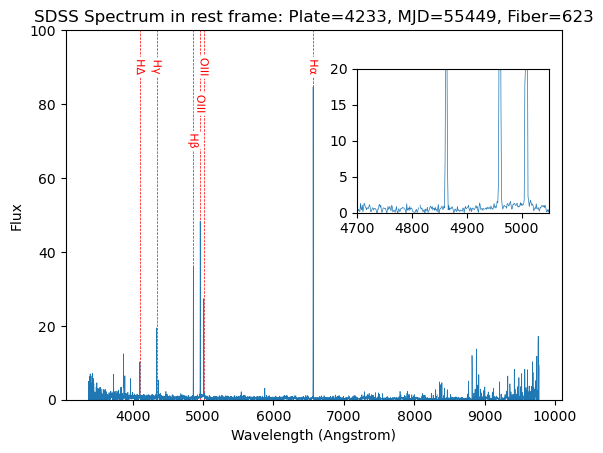

In [291]:
fig, ax = plt.subplots()

#common spectral lines in SDSS
xvals = [6564.61, 5008.240, 4960.295, 4862.68, 4102.89, 4341.68]
label = ['Hα', 'OIII', 'OIII', 'Hβ', 'HΔ', 'Hγ']

for i in range(len(xvals)):
     plt.axvline(xvals[i], color="red", linewidth=0.5, linestyle="--", label= label[i])

#plot the spectrum
ax.plot(wavelength/(1+z), flux, linewidth=0.5)
plt.xlabel("Wavelength (Angstrom)")
plt.ylabel("Flux")
plt.ylim(0,100)
plt.title(f"SDSS Spectrum in rest frame: Plate={plate}, MJD={mjd}, Fiber={fiber}")

#vertical lines
offset = [40, 40, 30, 20, 40, 40]
lines = plt.gca().get_lines()
labelLines(lines, align=True, yoffsets=offset, xvals = xvals, fontsize = 8)

#inset plot
inset = fig.add_axes([0.58, 0.5, 0.3, 0.3])
inset.plot(wavelength/(1+z), flux, linewidth=0.5)
inset.set_xlim(4700, 5050)
inset.set_ylim(0, 20)

plt.show()

In [287]:
def Gauss(x, amp, cen, wid):
    return amp * np.exp(-(x - cen)**2 / (2 * wid**2))

[3.61044175e+01 4.86262530e+03 1.20784925e+00]
[4.99733350e+01 4.96025024e+03 1.24223191e+00] [[ 7.19536667e-01  1.69718312e-06 -1.19263689e-02]
 [ 1.69718312e-06  5.93385234e-04 -1.71052325e-07]
 [-1.19263689e-02 -1.71052325e-07  5.93345181e-04]]
[2.72442464e+01 5.00850015e+03 2.10885827e+00] [[ 1.60782206e+01 -8.96453035e-03 -8.53659152e-01]
 [-8.96453035e-03  1.28102036e-01  1.76588329e-03]
 [-8.53659152e-01  1.76588329e-03  1.33182635e-01]]
[8.22836156e+01 6.56440291e+03 1.53904198e+00] [[ 2.29238940e+01  8.33296261e-04 -2.85363548e-01]
 [ 8.33296261e-04  1.07239996e-02 -3.11197346e-05]
 [-2.85363548e-01 -3.11197346e-05  1.06893502e-02]]


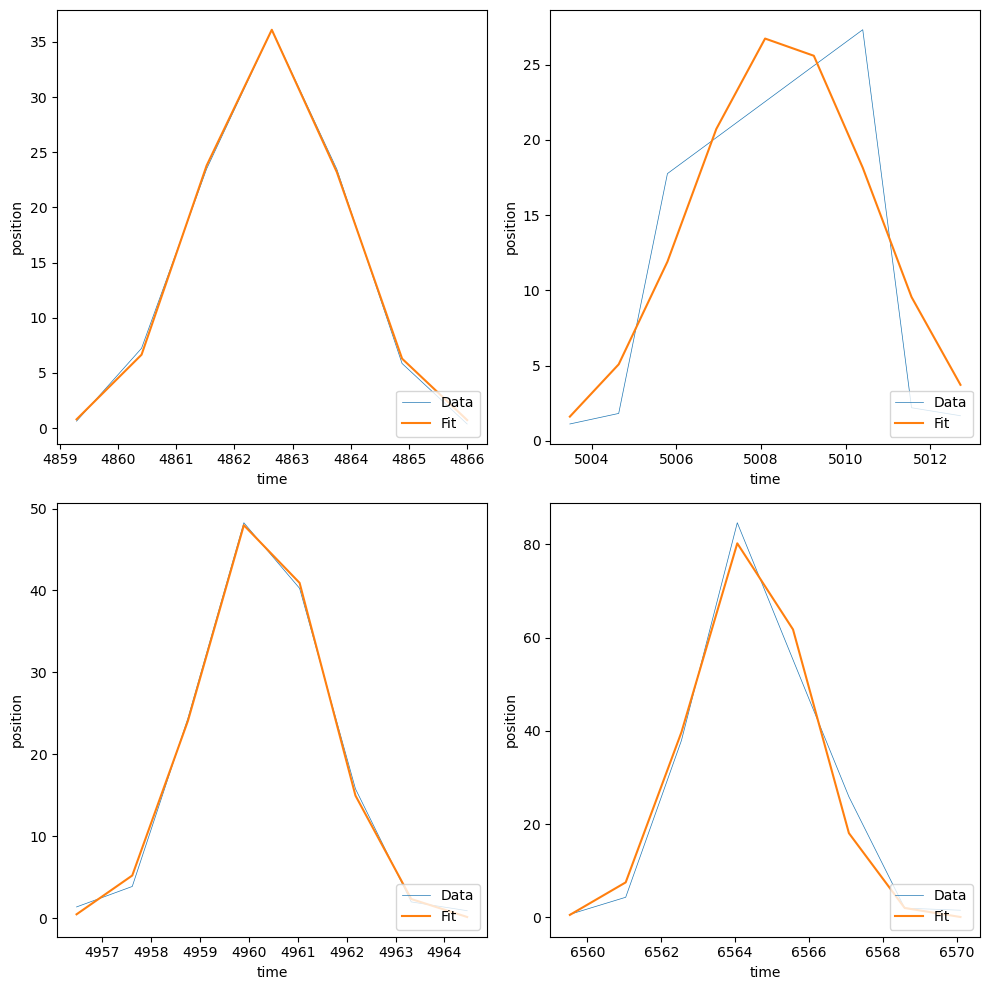

In [245]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
parameters, covariance = curve_fit(Gauss, wavelength[1586:1593]/(1+z), flux[1586:1593], method = "lm", p0=[30,4863,2])
print(parameters)
fit_A, fit_B, fit_C= parameters
fit_y = Gauss(wavelength[1586:1593]/(1+z), fit_A, fit_B, fit_C)

axs[0, 0].plot(wavelength[1586:1593]/(1+z), flux[1586:1593], linewidth=0.5, label='Data')
axs[0, 0].plot(wavelength[1586:1593]/(1+z), fit_y, '-', label='Fit')

parameters, covariance = curve_fit(Gauss, wavelength[1672:1680]/(1+z),flux[1672:1680], method = "lm", p0=[50,4960,4])
print(parameters, covariance)
fit_A, fit_B, fit_C = parameters
fit_y = Gauss(wavelength[1672:1680]/(1+z), fit_A, fit_B, fit_C)

axs[1, 0].plot(wavelength[1672:1680]/(1+z), flux[1672:1680], linewidth=0.5, label='Data')
axs[1, 0].plot(wavelength[1672:1680]/(1+z), fit_y, '-', label='Fit')

parameters, covariance = curve_fit(Gauss, wavelength[1713:1722]/(1+z),flux[1713:1722], method = "lm", p0=[20,5010,4])
print(parameters, covariance)
fit_A, fit_B, fit_C = parameters
fit_y = Gauss(wavelength[1713:1722]/(1+z), fit_A, fit_B, fit_C)

axs[0, 1].plot(wavelength[1713:1722]/(1+z), flux[1713:1722], linewidth=0.5, label='Data')
axs[0, 1].plot(wavelength[1713:1722]/(1+z), fit_y, '-', label='Fit')

parameters, covariance = curve_fit(Gauss, wavelength[2889:2897]/(1+z), flux[2889:2897], method = "lm", p0=[80,6564,4])
print(parameters, covariance)
fit_A, fit_B, fit_C = parameters
fit_y = Gauss(wavelength[2889:2897]/(1+z), fit_A, fit_B, fit_C)

axs[1, 1].plot(wavelength[2889:2897]/(1+z), flux[2889:2897], linewidth=0.5, label='Data')
axs[1, 1].plot(wavelength[2889:2897]/(1+z), fit_y, '-', label='Fit')

for ax in axs.flat:
    ax.set(xlabel='time', ylabel='position')
    ax.legend(loc="lower right")

fig.tight_layout()

plt.savefig("Gaussian.png")
plt.show()